In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer # Look if wee need this in time series (wheter it can do forward or backwards fill)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.decomposition import PCA
import wbgapi as wb

In [ ]:
# Load dataset & attach indicator descriptions
 - On reload, I attached the World Bank’s official series descriptions next to my abbreviations. This creates a built-in data dictionary for interpretation and reporting.

In [272]:
pd.set_option('display.width', None) 
Indicators = {"series": ["SL.UEM.TOTL.ZS", "NY.GDP.MKTP.KD.ZG", "NE.CON.PRVT.KD.ZG", 
               "NE.CON.GOVT.KD.ZG", "NE.GDI.TOTL.KD.ZG", "NE.EXP.GNFS.KD.ZG", 
               "NE.IMP.GNFS.KD.ZG", "NV.IND.TOTL.KD.ZG", "NV.SRV.TOTL.KD.ZG", 
               "NV.AGR.TOTL.KD.ZG", "FP.CPI.TOTL.ZG", "NY.GDP.DEFL.KD.ZG", 
               "FR.INR.DPST", "FR.INR.RINR", "FM.LBL.MQMY.GD.ZS", "SL.TLF.CACT.ZS",
               "SL.EMP.TOTL.SP.ZS", "SP.POP.GROW", "NY.GNS.ICTR.ZS"]}
column_names = {
    "FP.CPI.TOTL.ZG": "cpi_inflation_pct",
    "FR.INR.DPST": "deposit_rate_pct",
    "FR.INR.RINR": "real_interest_rate_pct",
    "NE.CON.GOVT.KD.ZG": "govt_consumption_growth_pct",
    "NE.CON.PRVT.KD.ZG": "private_consumption_growth_pct",
    "NE.EXP.GNFS.KD.ZG": "exports_growth_pct",
    "NE.GDI.TOTL.KD.ZG": "gross_capital_form_growth_pct",
    "NE.IMP.GNFS.KD.ZG": "imports_growth_pct",
    "NV.AGR.TOTL.KD.ZG": "agriculture_growth_pct",
    "NV.IND.TOTL.KD.ZG": "industry_growth_pct",
    "NV.SRV.TOTL.KD.ZG": "services_growth_pct",
    "NY.GDP.DEFL.KD.ZG": "gdp_deflator_inflation_pct",
    "NY.GDP.MKTP.KD.ZG": "gdp_growth_pct",
    "NY.GNS.ICTR.ZS": "gross_savings_gdp_pct",
    "SL.EMP.TOTL.SP.ZS": "employment_ratio_pct",
    "SL.TLF.CACT.ZS": "labor_force_participation_pct",
    "SL.UEM.TOTL.ZS": "unemployment_rate_pct",
    "SP.POP.GROW": "population_growth_pct",
}

In [273]:
dataset = pd.read_csv(r'D:\Python\PycharmProjects\Bundesbank\unemplyoment_data.csv', parse_dates=["years"])

- Additional information about the features used in the analysis

In [274]:
df_unique = dataset.copy()
info = wb.series.Series(Indicators['series']).to_dict()
df_info = pd.DataFrame(list(info.items()), columns=['series', 'description'])
df_info 
df_info["Abbreviation"] = df_info["series"].map(column_names)
df_info 

,series,description,Abbreviation
0,NV.AGR.TOTL.KD.ZG,"Agriculture, forestry, and fishing, value adde...",agriculture_growth_pct
1,FR.INR.DPST,Deposit interest rate (%),deposit_rate_pct
2,SL.EMP.TOTL.SP.ZS,"Employment to population ratio, 15+, total (%)...",employment_ratio_pct
3,NE.EXP.GNFS.KD.ZG,Exports of goods and services (annual % growth),exports_growth_pct
4,NY.GDP.MKTP.KD.ZG,GDP growth (annual %),gdp_growth_pct
5,NE.CON.GOVT.KD.ZG,General government final consumption expenditu...,govt_consumption_growth_pct
6,NE.GDI.TOTL.KD.ZG,Gross capital formation (annual % growth),gross_capital_form_growth_pct
7,NY.GNS.ICTR.ZS,Gross savings (% of GDP),gross_savings_gdp_pct
8,NE.CON.PRVT.KD.ZG,Households and NPISHs Final consumption expend...,private_consumption_growth_pct
9,NE.IMP.GNFS.KD.ZG,Imports of goods and services (annual % growth),imports_growth_pct


# Audit missingness (level & structure)
- I quantified missing values per feature and visualized the missing values distribtuion across years. 
- All values of the Target variable are missing until 1991 (subset whole dataset until here)
- Next filter out economies with every value missing in the target variable
    - I removed countries with >80% missing unemployment in the modeled window. This avoids training on label-scarce series that would inject noise into cross-country patterns.
- I dropped variables whose missingness stayed above ~30% (e.g., real/nominal deposit rates)

In [275]:
print(dataset.isna().sum()/len(dataset))
print(dataset.info())


Unnamed: 0                        0.000000
years                             0.000000
economy                           0.000000
cpi_inflation_pct                 0.268820
deposit_rate_pct                  0.517047
real_interest_rate_pct            0.536401
govt_consumption_growth_pct       0.416451
private_consumption_growth_pct    0.408462
exports_growth_pct                0.385619
gross_capital_form_growth_pct     0.440756
imports_growth_pct                0.385619
agriculture_growth_pct            0.297851
industry_growth_pct               0.309103
services_growth_pct               0.331946
gdp_deflator_inflation_pct        0.108473
gdp_growth_pct                    0.106110
gross_savings_gdp_pct             0.399572
population_growth_pct             0.000225
employment_ratio_pct              0.368741
labor_force_participation_pct     0.347699
unemployment_rate_pct             0.368741
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8887 entries, 0 to 8886
Data col

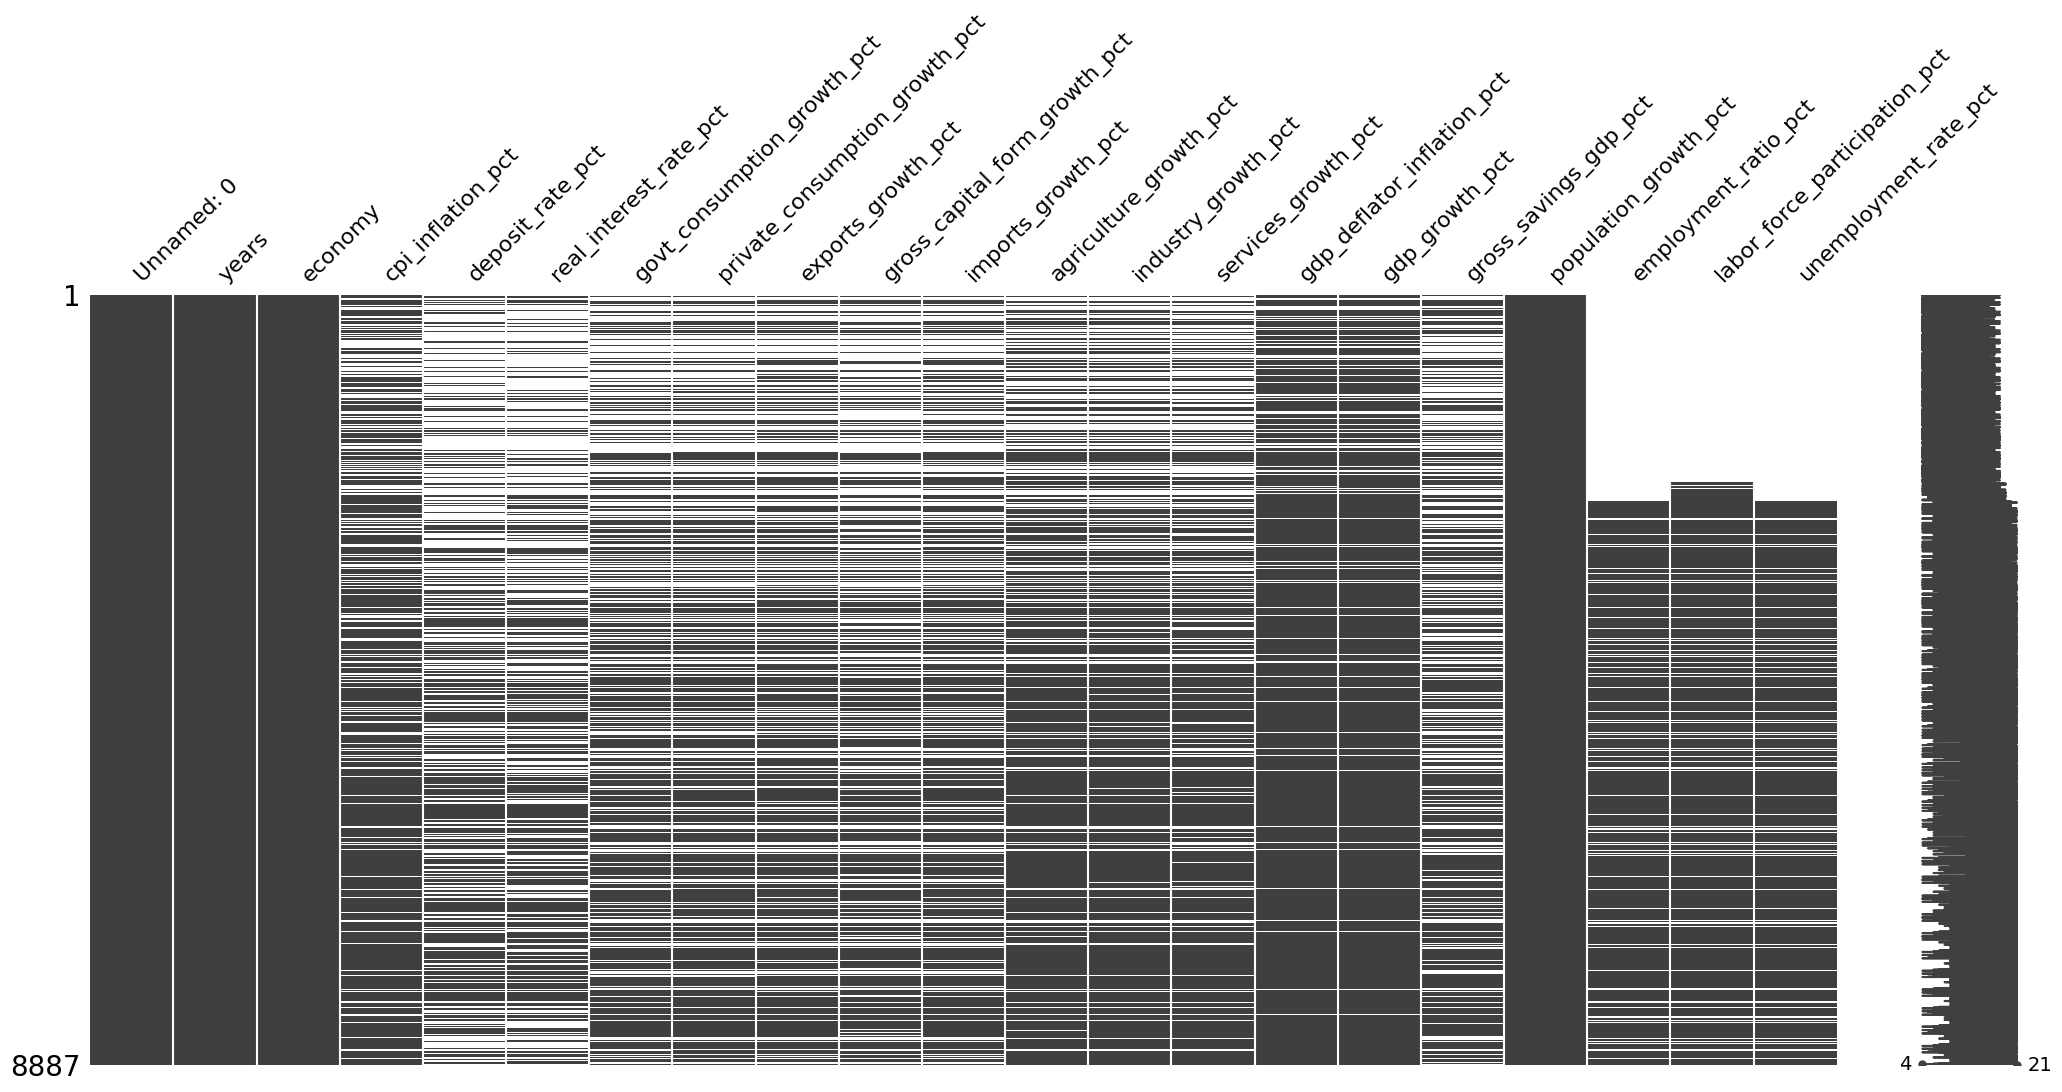

In [276]:
msno.matrix(dataset.sort_values("years")) 
plt.show()

In [277]:
df_miss = dataset[["economy","years","employment_ratio_pct", "labor_force_participation_pct", "unemployment_rate_pct"]]
first_non_dates = {}
for col in df_miss.columns:
    first_valid_index = df_miss[col].first_valid_index()
    first_non_dates[col] = df_miss.loc[first_valid_index, "years"]

print(first_non_dates)
# So until 1991 the unemployment rate isn't given. Our Traget varaible so subset until here

{'economy': Timestamp('1980-01-01 00:00:00'), 'years': Timestamp('1980-01-01 00:00:00'), 'employment_ratio_pct': Timestamp('1991-01-01 00:00:00'), 'labor_force_participation_pct': Timestamp('1990-01-01 00:00:00'), 'unemployment_rate_pct': Timestamp('1991-01-01 00:00:00')}


In [278]:
df_cleaned_year = dataset.loc[dataset["years"] >= '1991-01-01 00:00:00',:]

In [279]:
# Filter out ecnomies where the Target variable isn't given 
missing_economies = df_cleaned_year.groupby("economy")["unemployment_rate_pct"].apply(lambda x: x.isna().sum())
missing_economies.sort_values(ascending = False)

economy
ABW    30
TUV    30
MNP    30
FRO    30
TCA    30
       ..
HKG     0
HND     0
HRV     0
HTI     0
ZWE     0
Name: unemployment_rate_pct, Length: 217, dtype: int64

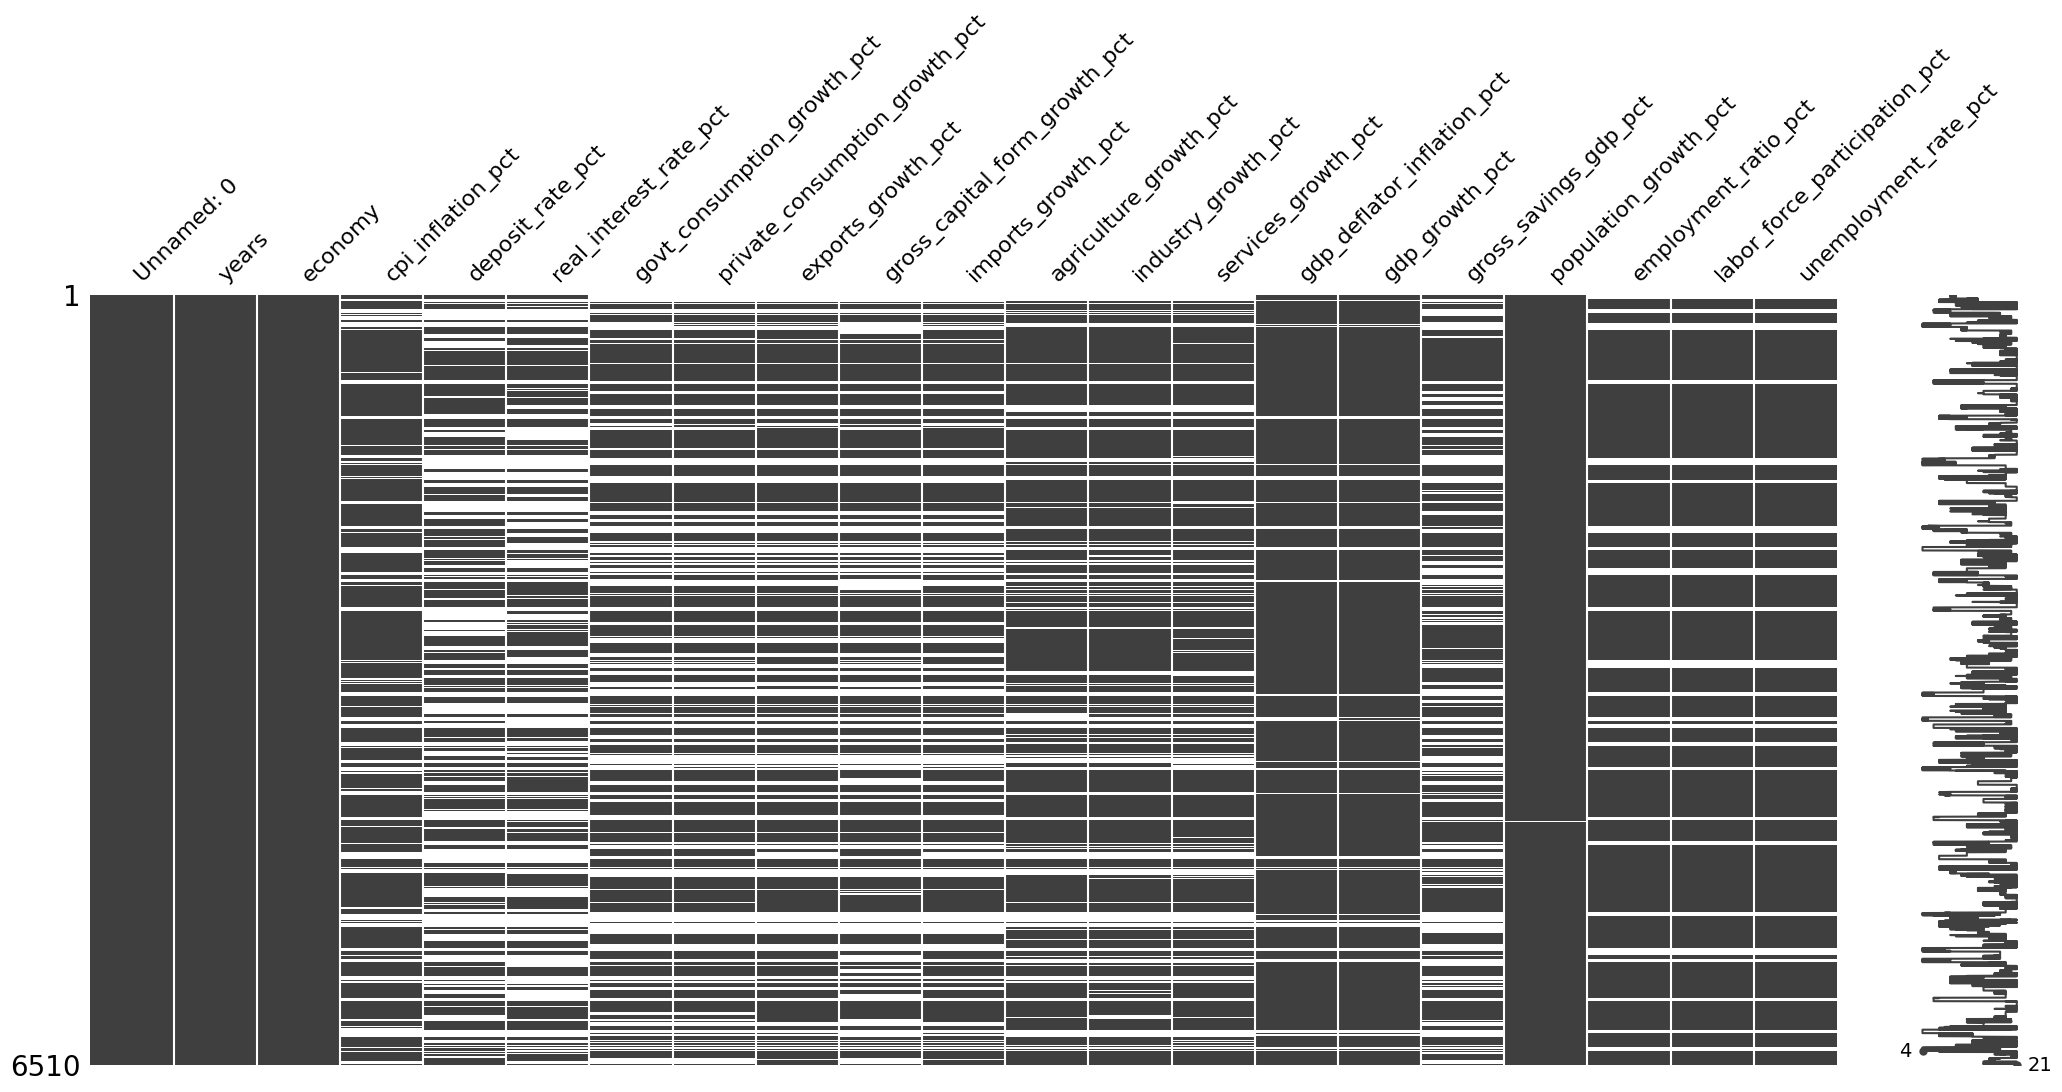

Index(['ABW', 'AND', 'ASM', 'ATG', 'BMU', 'CUW', 'CYM', 'DMA', 'FRO', 'FSM',
       'GIB', 'GRD', 'GRL', 'IMN', 'KIR', 'KNA', 'LIE', 'MAF', 'MCO', 'MHL',
       'MNP', 'NRU', 'PLW', 'SMR', 'SXM', 'SYC', 'TCA', 'TUV', 'VGB', 'XKX'],
      dtype='object', name='economy')
30
187


In [280]:
msno.matrix(df_cleaned_year.sort_values("economy")) 
plt.show()
missing_economies = df_cleaned_year.groupby("economy")["unemployment_rate_pct"].apply(lambda x: (x.isna().sum()/len(x)) > 0.8)
to_drop = missing_economies.index[missing_economies]
print(to_drop)
print(len(to_drop))
df_kept = df_cleaned_year[~df_cleaned_year["economy"].isin(to_drop)]
print(len(df_kept["economy"].unique()))

In [281]:
print(df_kept.isna().sum()/len(df_kept))
# as one can see the percentage of missing values clearly decreased substantially across the board
# However there are still many values with very high amount of missing values like depost_rate_pct and real_interest_rate_pct

Unnamed: 0                        0.000000
years                             0.000000
economy                           0.000000
cpi_inflation_pct                 0.132442
deposit_rate_pct                  0.391444
real_interest_rate_pct            0.414617
govt_consumption_growth_pct       0.262032
private_consumption_growth_pct    0.255615
exports_growth_pct                0.237968
gross_capital_form_growth_pct     0.290374
imports_growth_pct                0.237968
agriculture_growth_pct            0.148307
industry_growth_pct               0.157932
services_growth_pct               0.176649
gdp_deflator_inflation_pct        0.032442
gdp_growth_pct                    0.032264
gross_savings_gdp_pct             0.264171
population_growth_pct             0.000178
employment_ratio_pct              0.000000
labor_force_participation_pct     0.000000
unemployment_rate_pct             0.000000
dtype: float64


In [282]:
# drop features with above 30% missing values
df_kept = df_kept.drop(columns=["real_interest_rate_pct","deposit_rate_pct"])

In [ ]:
# Data Exploration for imputation
- Merged World Bank classifications (region, income group). 
    - These categorical covariates aid imputation (group medians) 
- Removed Venezuela rows lacking a stable income-group label to avoid ambiguous group imputations 
- Identified structural differences in the variables across subgroup by using KDEs
- 'cpi_inflation_pct', 'gdp_deflator_inflation_pct', 'gross_savings_gdp_pct' could benefit from subgroup based  imputation

In [283]:
# While filling the missing values it is important to preserve the trend structure
# Also for better imputation impute by subgroups like continent or income_group if the distribution differ according to this categories
url = 'https://databank.worldbank.org/data/download/site-content/CLASS.xlsx'
classifications = pd.ExcelFile(url)
classifications = pd.read_excel(url, sheet_name="List of economies", header= 0)
classifications = classifications[["Code", "Income group", "Region"]]
print(classifications["Region"].unique())
print(classifications.duplicated(subset = ["Code"]).sum())

df_kept = df_kept.merge(classifications, left_on = "economy", right_on = "Code", how = "left")
df_kept = df_kept.drop(columns=['Unnamed: 0', 'Code'])
df_kept.columns = (
    df_kept.columns
    .str.replace('Income group', 'income_group')
    .str.replace('Region', 'region')
)

['Latin America & Caribbean' 'South Asia' 'Sub-Saharan Africa'
 'Europe & Central Asia' 'Middle East & North Africa'
 'East Asia & Pacific' 'North America' nan]
0


In [284]:
print(df_kept["region"].isna().sum())
print(df_kept["income_group"].isna().sum())
print(df_kept.loc[df_kept["income_group"].isna(),["economy"]])
# One country isn't labeld in a specific income group so harder to impute just leave it out
df_kept = df_kept.loc[df_kept["economy"] != 'VEN', :]

0
30
     economy
178      VEN
365      VEN
552      VEN
739      VEN
926      VEN
1113     VEN
1300     VEN
1487     VEN
1674     VEN
1861     VEN
2048     VEN
2235     VEN
2422     VEN
2609     VEN
2796     VEN
2983     VEN
3170     VEN
3357     VEN
3544     VEN
3731     VEN
3918     VEN
4105     VEN
4292     VEN
4479     VEN
4666     VEN
4853     VEN
5040     VEN
5227     VEN
5414     VEN
5601     VEN


In [285]:
print(df_kept.columns)
print(df_kept["income_group"].unique())

Index(['years', 'economy', 'cpi_inflation_pct', 'govt_consumption_growth_pct',
       'private_consumption_growth_pct', 'exports_growth_pct',
       'gross_capital_form_growth_pct', 'imports_growth_pct',
       'agriculture_growth_pct', 'industry_growth_pct', 'services_growth_pct',
       'gdp_deflator_inflation_pct', 'gdp_growth_pct', 'gross_savings_gdp_pct',
       'population_growth_pct', 'employment_ratio_pct',
       'labor_force_participation_pct', 'unemployment_rate_pct',
       'income_group', 'region'],
      dtype='object')
['Low income' 'Lower middle income' 'Upper middle income' 'High income']


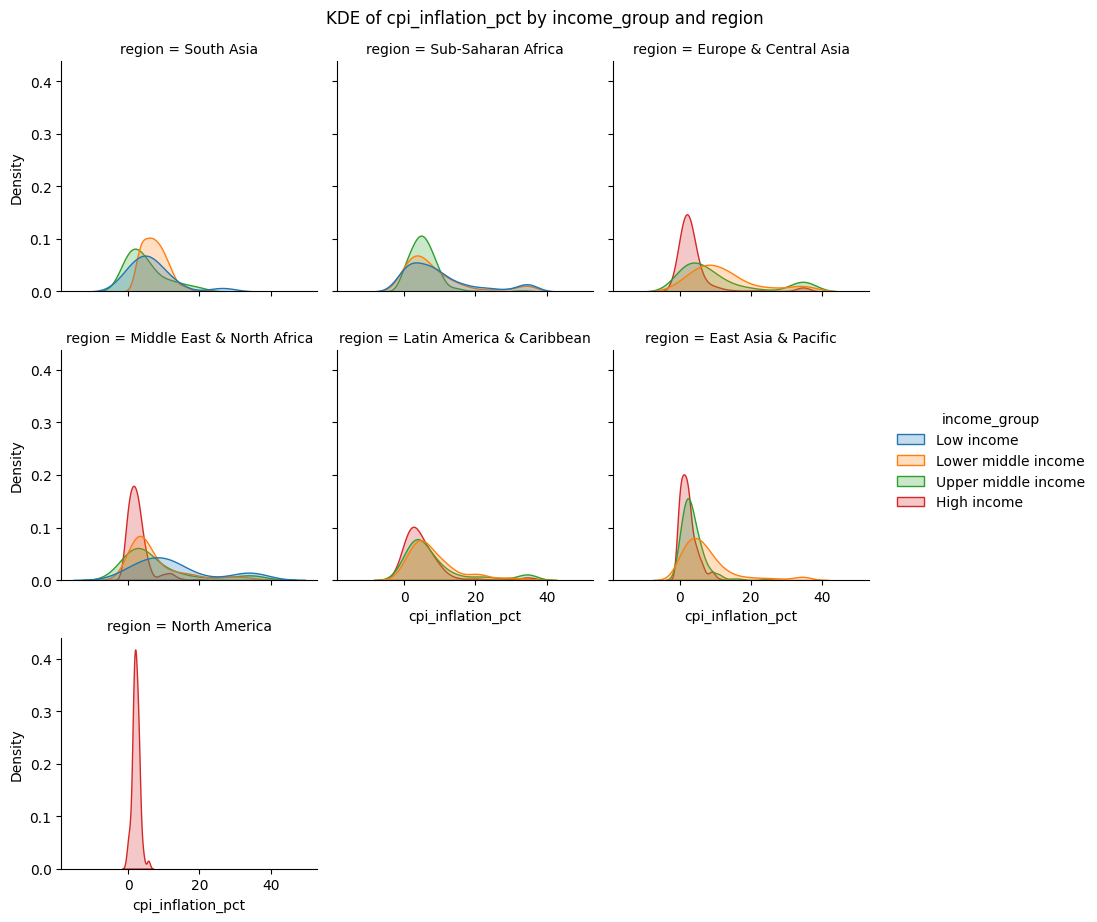

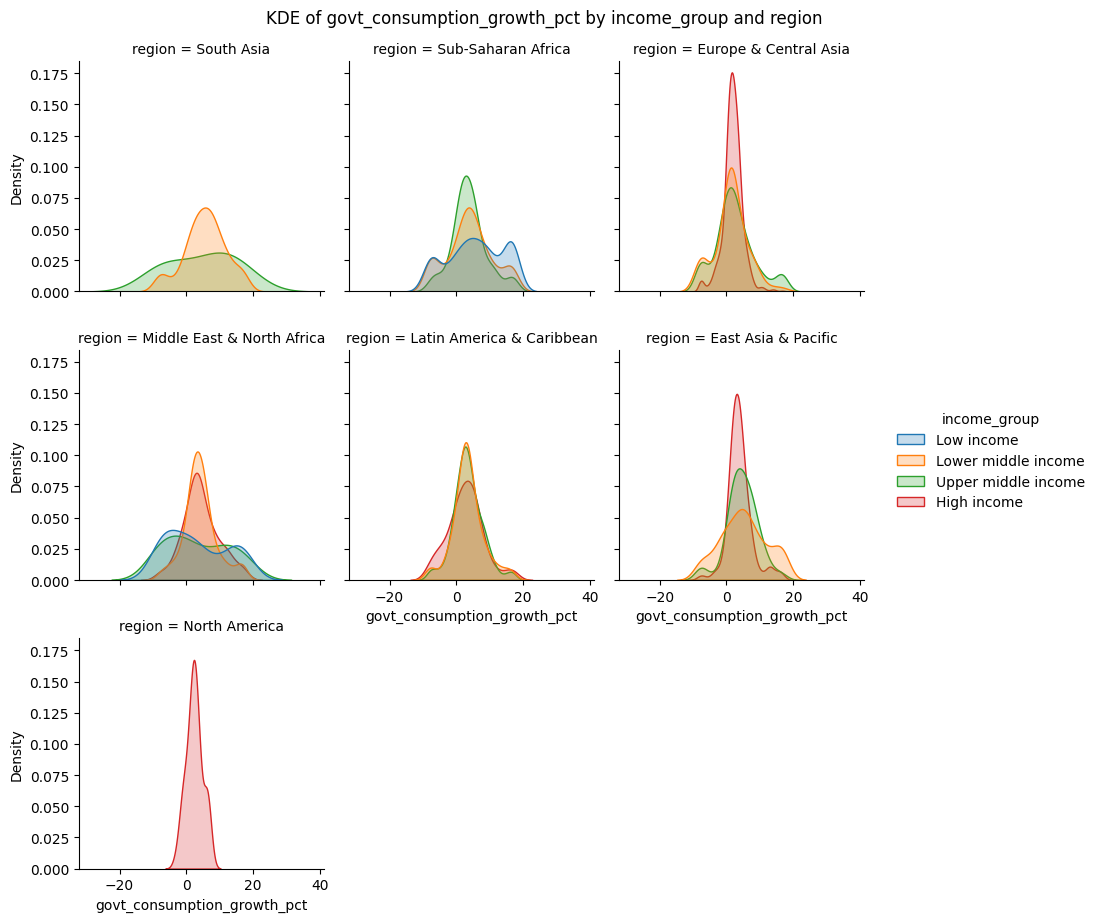

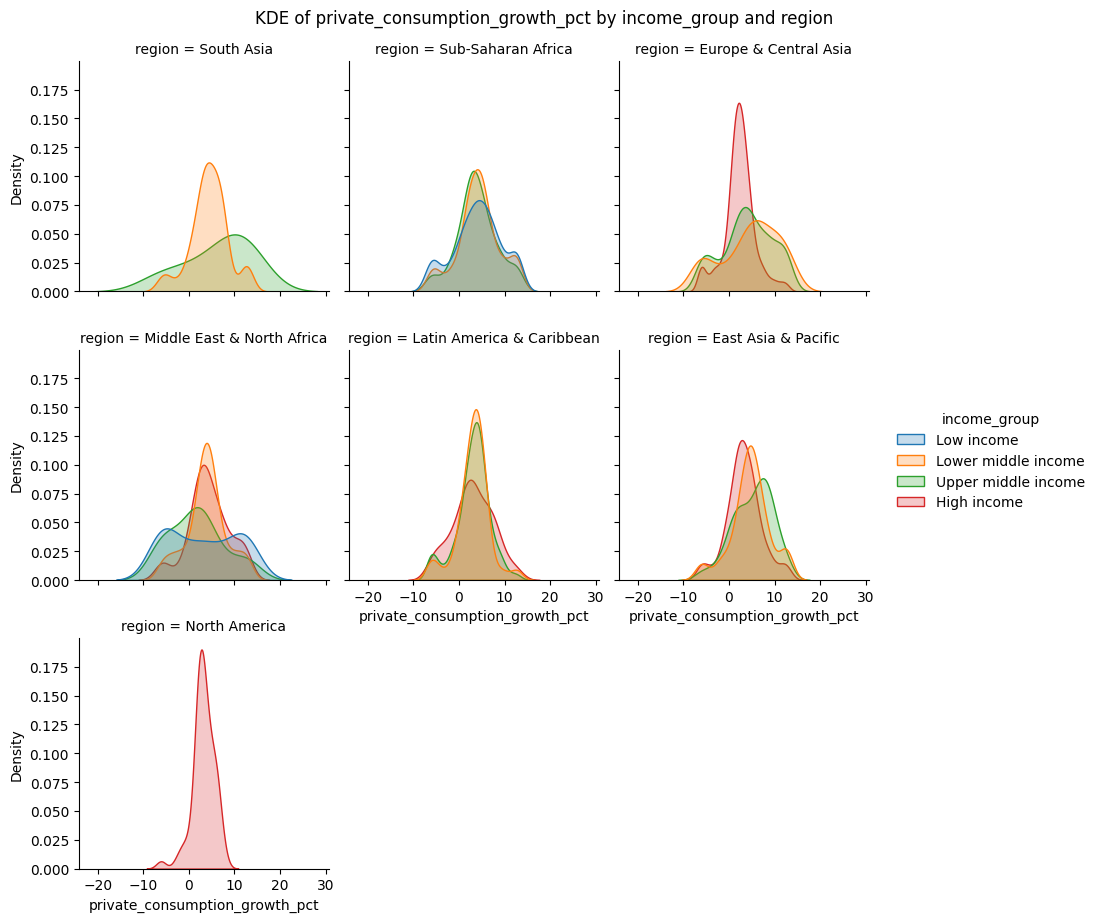

In [286]:
def kde_by_region_and_income(df, cols, lower_q=0.05, upper_q=0.95, hue_order=None):
    df_plot = df.copy()
    
    # So outlier vanish and we can have a better view of the differences in distribution
    for c in cols:
        lo, hi = df_plot[c].quantile([lower_q, upper_q])
        df_plot[c] = np.clip(df_plot[c], lo, hi)

    for c in cols:
        g = sns.displot(
            data=df_plot,
            x=c,
            hue="income_group",
            hue_order=hue_order,
            col="region",      
            kind="kde",
            fill=True,
            common_norm=False,  
            col_wrap=3,           
            height=3
        )
        g.fig.suptitle(f"KDE of {c} by income_group and region", y=1.02)
        plt.show()

# Usage
cols = ['cpi_inflation_pct', 'govt_consumption_growth_pct', 'private_consumption_growth_pct']
hue_order = ['Low income' ,'Lower middle income' ,'Upper middle income', 'High income']

kde_by_region_and_income(df_kept, cols, lower_q=0.05, upper_q=0.95, hue_order=hue_order)

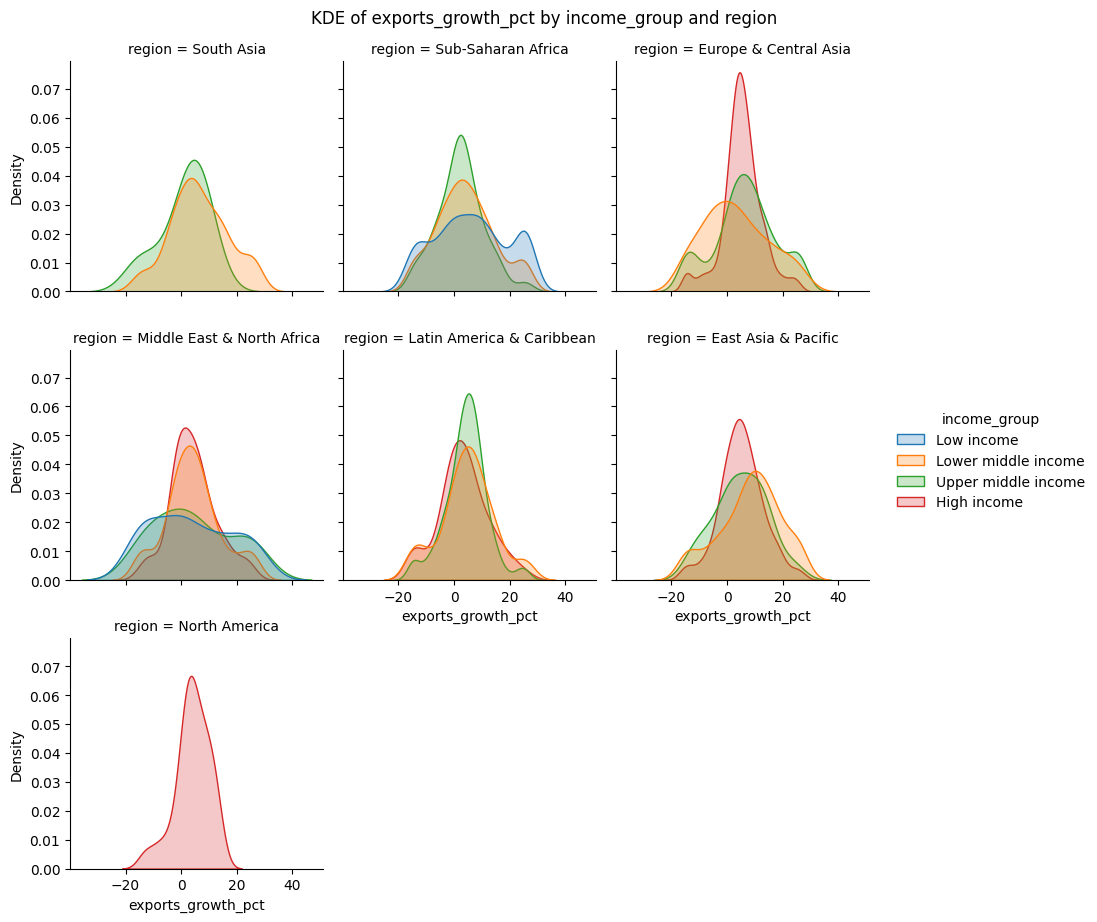

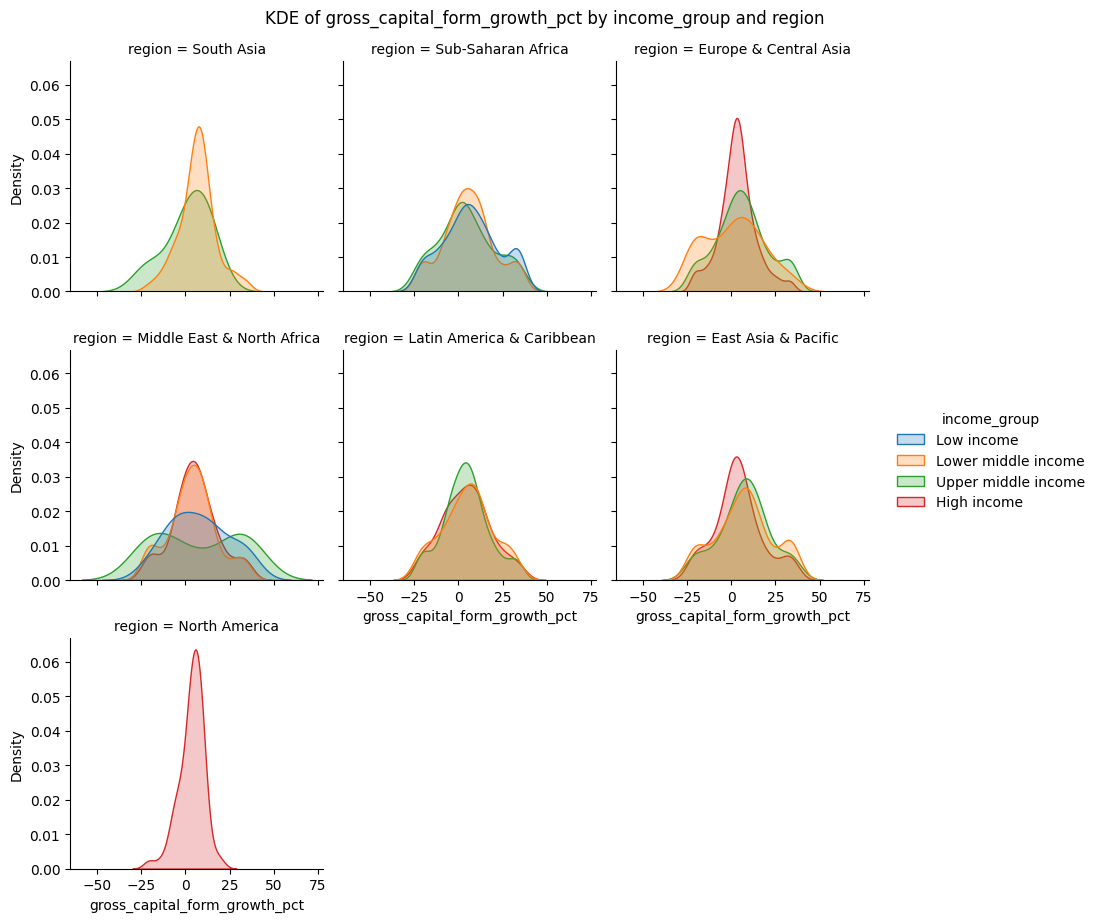

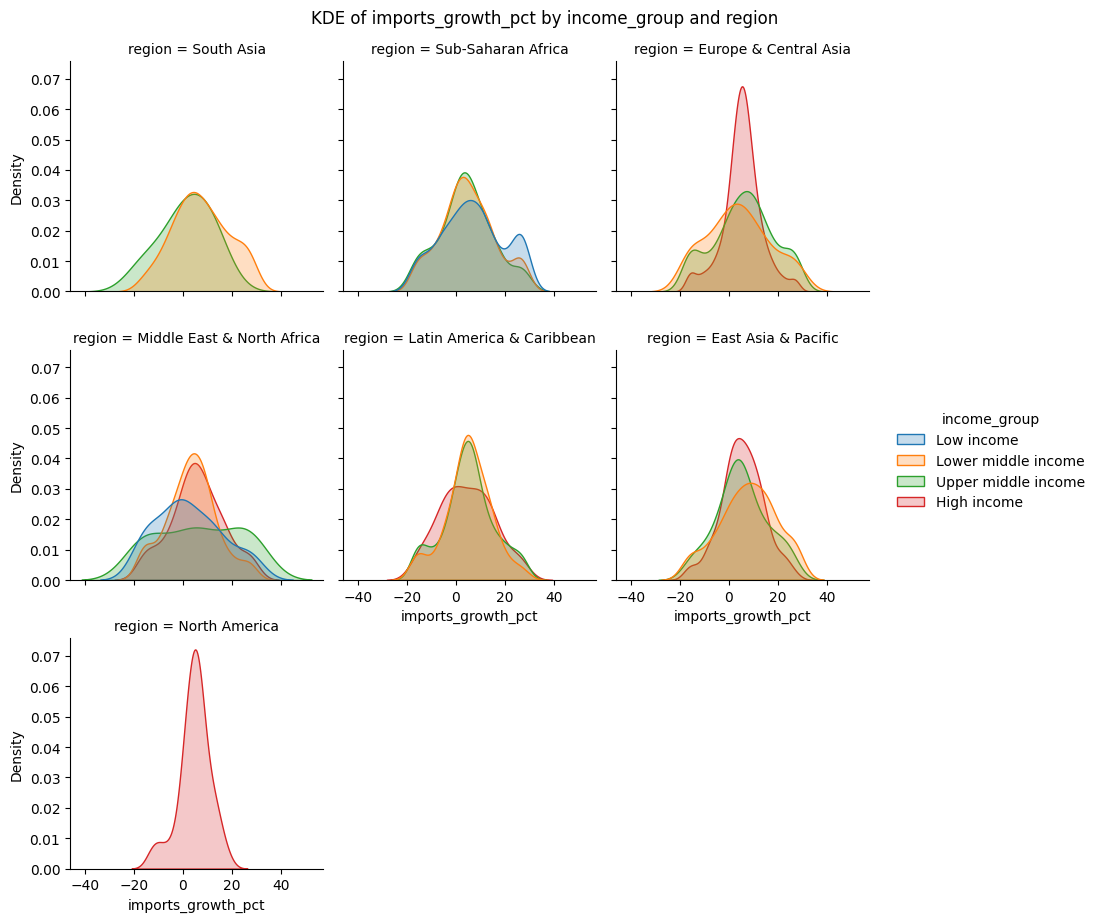

In [287]:
cols = ['exports_growth_pct','gross_capital_form_growth_pct', 'imports_growth_pct']
kde_by_region_and_income(df_kept, cols, lower_q=0.05, upper_q=0.95, hue_order=hue_order)

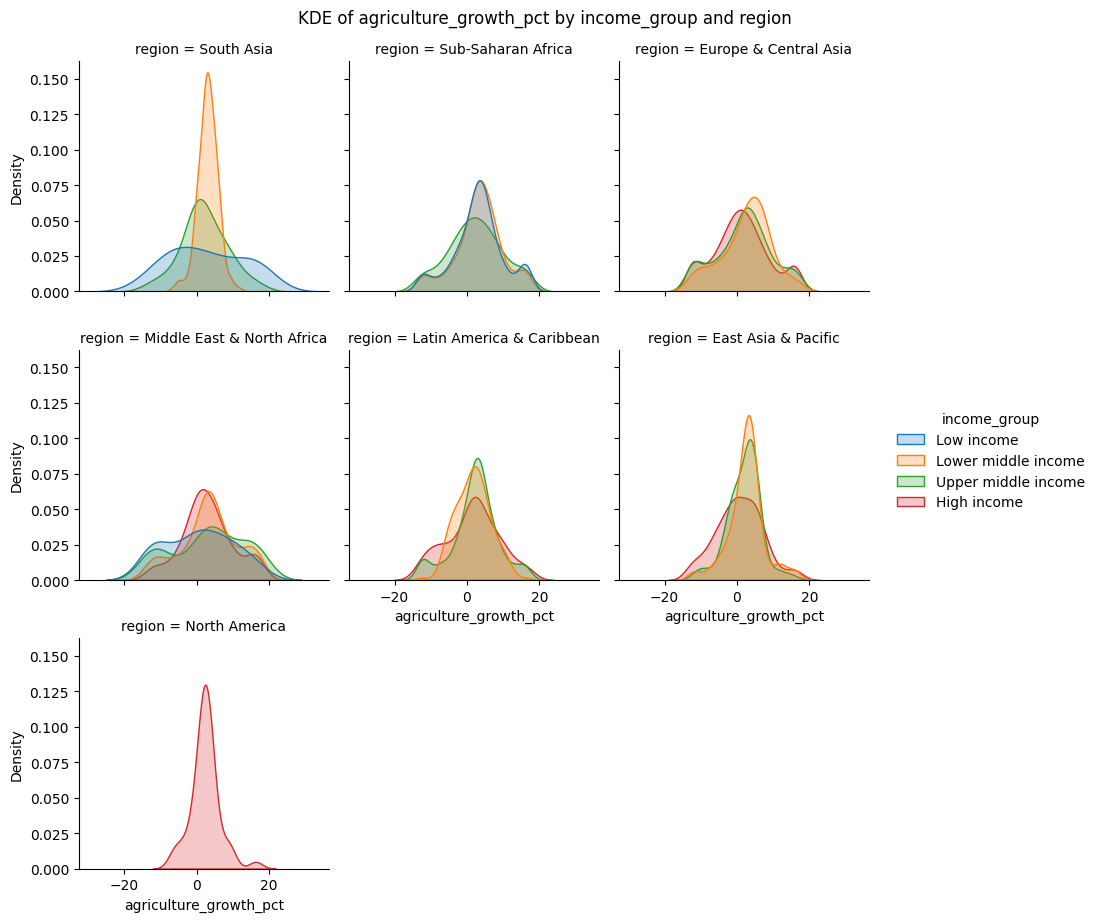

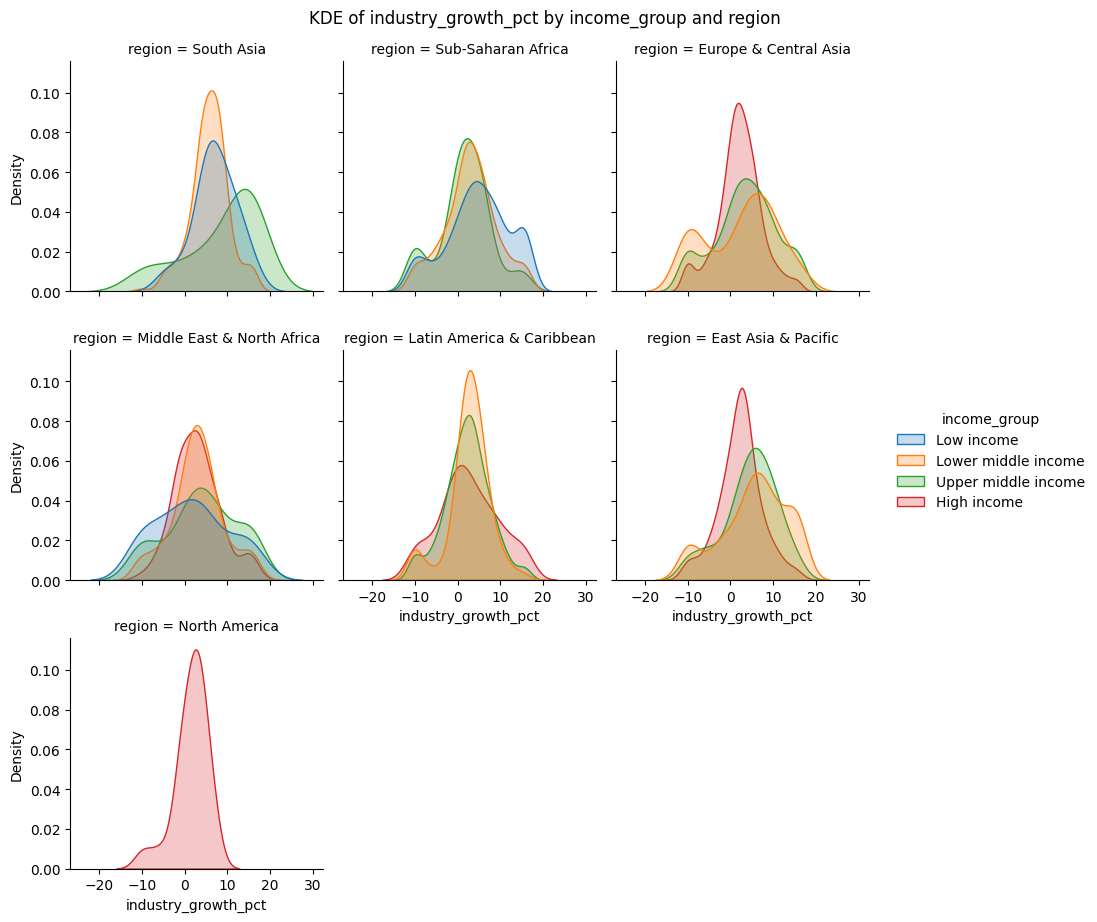

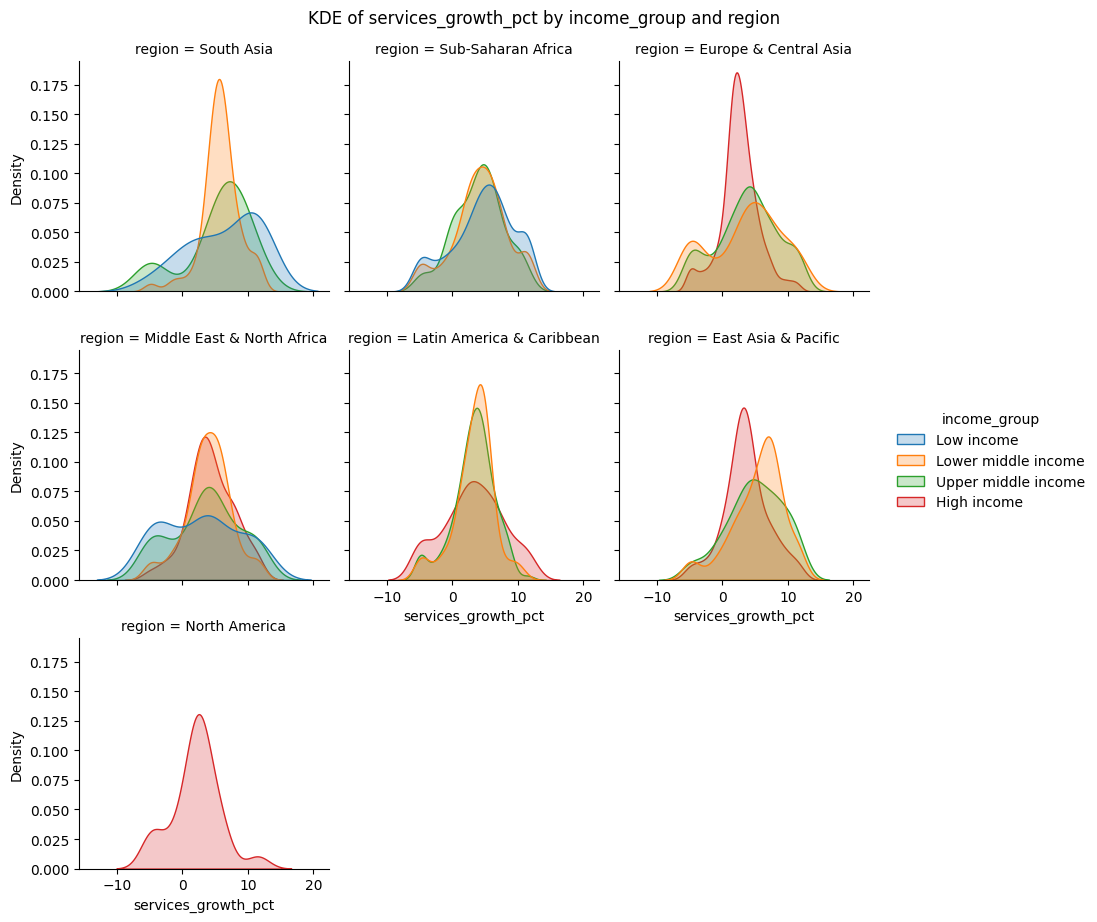

In [288]:
cols =['agriculture_growth_pct', 'industry_growth_pct', 'services_growth_pct']
kde_by_region_and_income(df_kept, cols, lower_q=0.05, upper_q=0.95, hue_order=hue_order)

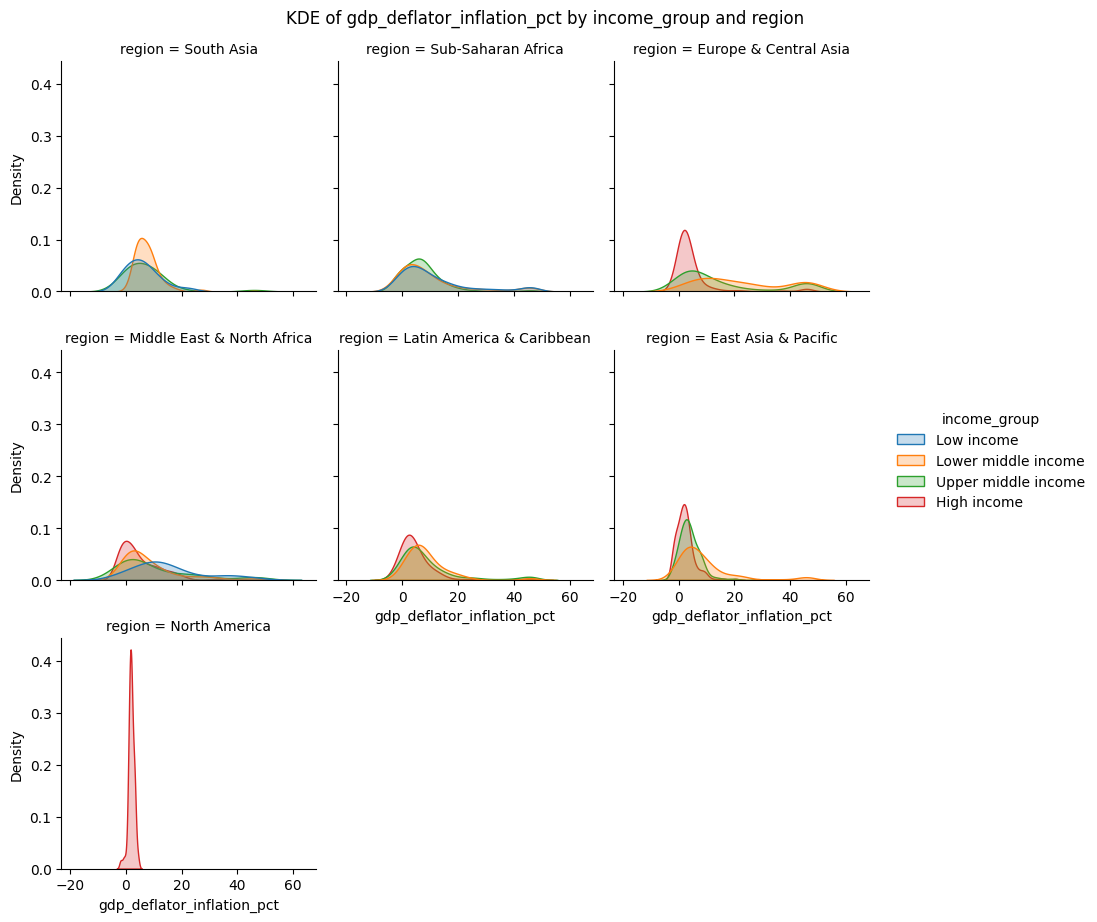

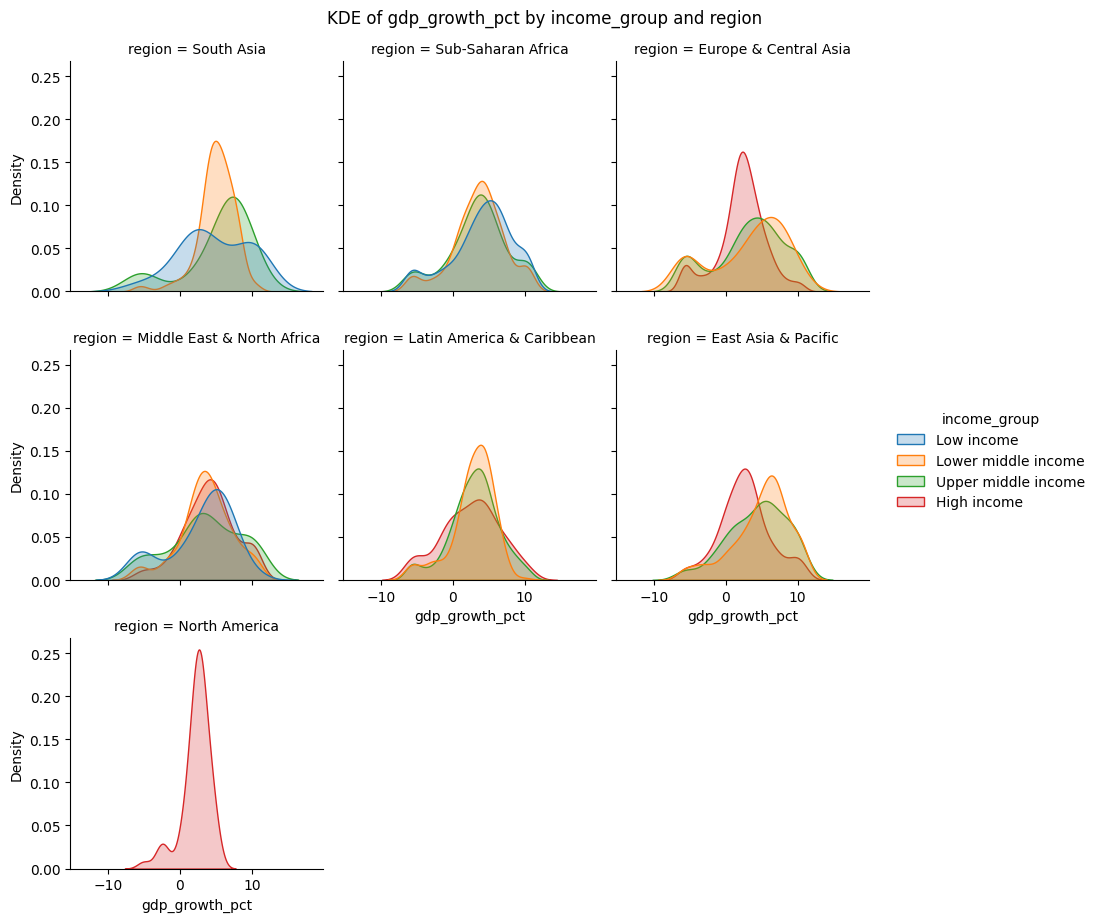

C:\Users\Niklas\AppData\Local\Temp\ipykernel_11676\3001631399.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(


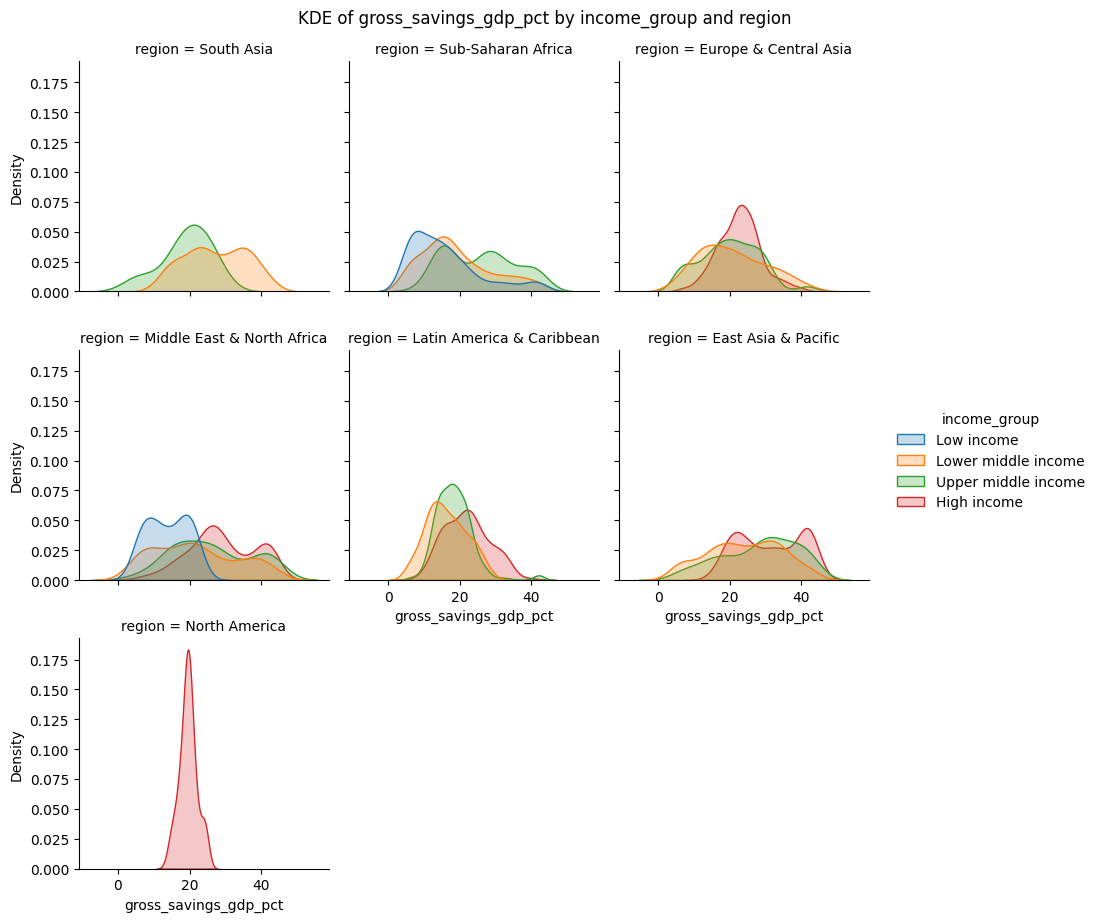

In [289]:
cols =['gdp_deflator_inflation_pct', 'gdp_growth_pct', 'gross_savings_gdp_pct']
kde_by_region_and_income(df_kept, cols, lower_q=0.05, upper_q=0.95, hue_order=hue_order)

# Imputation
- I sorted by year and split chronologically (≈80/20) so the model only learns from the past to predict the future—no leakage from the “future” into training.
- Filled gaps in this order for columns with subgroup imputation:
    - (1) within-country forward/backward fill to preserve local trends
    - (2) median by income×region for macro similarity
    - (3) income-only median
    - (4) global median.
- Filled gaps in this order for columns without subgroup imputation
    - (1) within-country forward/backward fill to preserve local trends
    - (4) global median

- I applied stored medians from the training set to the test set to avoid data leakage

In [290]:
df_kept = df_kept.sort_values('years').reset_index(drop=True)

# Define train/test split index (e.g. 80% train)
split_idx = int(len(df_kept) * 0.8)
train_df = df_kept.iloc[:split_idx].copy()
test_df  = df_kept.iloc[split_idx:].copy()

In [291]:
train_df = train_df.sort_values(['economy','years'])
col_income_region_imputation = train_df.loc[:,['cpi_inflation_pct', 'gdp_deflator_inflation_pct', 'gross_savings_gdp_pct']].columns
median_grp    = train_df.groupby(['income_group','region'])[col_income_region_imputation].median()
median_inc    = train_df.groupby(['income_group'])[col_income_region_imputation].median()
global_median = train_df[col_income_region_imputation].median()


In [292]:
# Imputation
train_df = train_df.sort_values(['economy','years'])
cols_missing_values = train_df.columns[train_df.isna().sum() >0]
print(cols_missing_values)
# Using here the most specific subgroups to imputate the missing values
for col in cols_missing_values:
    train_df[col] =  train_df.groupby("economy")[col].ffill()
    train_df[col] =  train_df.groupby("economy")[col].bfill()


for col in col_income_region_imputation:
    train_df[col] = train_df.groupby(['income_group','region'])[col].transform(lambda x: x.fillna(x.median()))
    train_df[col] = train_df.groupby('income_group')[col].transform(lambda x: x.fillna(x.median()))
    train_df[col] = train_df[col].fillna(train_df[col].median())

cols_missing_values = train_df.columns[train_df.isna().sum() >0]
for col in cols_missing_values:
        train_df[col] =  train_df[col].fillna(train_df[col].median())
print(train_df.isna().sum())

Index(['cpi_inflation_pct', 'govt_consumption_growth_pct',
       'private_consumption_growth_pct', 'exports_growth_pct',
       'gross_capital_form_growth_pct', 'imports_growth_pct',
       'agriculture_growth_pct', 'industry_growth_pct', 'services_growth_pct',
       'gdp_deflator_inflation_pct', 'gdp_growth_pct', 'gross_savings_gdp_pct',
       'population_growth_pct'],
      dtype='object')
years                             0
economy                           0
cpi_inflation_pct                 0
govt_consumption_growth_pct       0
private_consumption_growth_pct    0
exports_growth_pct                0
gross_capital_form_growth_pct     0
imports_growth_pct                0
agriculture_growth_pct            0
industry_growth_pct               0
services_growth_pct               0
gdp_deflator_inflation_pct        0
gdp_growth_pct                    0
gross_savings_gdp_pct             0
population_growth_pct             0
employment_ratio_pct              0
labor_force_participation_

D:\Python\PycharmProjects\Bundesbank\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\Python\PycharmProjects\Bundesbank\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\Python\PycharmProjects\Bundesbank\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\Python\PycharmProjects\Bundesbank\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [293]:
test_df = test_df.sort_values(['economy','years'])
cols_missing_values = test_df.columns[test_df.isna().sum() >0]
print(cols_missing_values)


for col in cols_missing_values:
    test_df[col] = test_df.groupby('economy')[col].ffill()
    test_df[col] = test_df.groupby('economy')[col].bfill()

for col in col_income_region_imputation:
    # merge or map each row’s (income_group, region) to the stored median
    # Can't use the year specification here as we split by year through sorting
    test_df[col] = test_df.apply(
        lambda row: (
            median_grp.loc[(row['income_group'], row['region']), col]
            if (row['income_group'], row['region']) in median_grp.index
            else median_inc.loc[row['income_group'], col]
            if row['income_group'] in median_inc.index
            else global_median[col]
        ) if pd.isna(row[col]) else row[col],
        axis=1
    )
cols_missing_values = test_df.columns[test_df.isna().sum() >0]
for col in cols_missing_values:
     test_df[col] =  test_df[col].fillna(train_df[col].median())

Index(['cpi_inflation_pct', 'govt_consumption_growth_pct',
       'private_consumption_growth_pct', 'exports_growth_pct',
       'gross_capital_form_growth_pct', 'imports_growth_pct',
       'agriculture_growth_pct', 'industry_growth_pct', 'services_growth_pct',
       'gdp_deflator_inflation_pct', 'gdp_growth_pct',
       'gross_savings_gdp_pct'],
      dtype='object')


In [294]:
print(test_df.isna().sum())

years                             0
economy                           0
cpi_inflation_pct                 0
govt_consumption_growth_pct       0
private_consumption_growth_pct    0
exports_growth_pct                0
gross_capital_form_growth_pct     0
imports_growth_pct                0
agriculture_growth_pct            0
industry_growth_pct               0
services_growth_pct               0
gdp_deflator_inflation_pct        0
gdp_growth_pct                    0
gross_savings_gdp_pct             0
population_growth_pct             0
employment_ratio_pct              0
labor_force_participation_pct     0
unemployment_rate_pct             0
income_group                      0
region                            0
dtype: int64


# Lag feature engineering
- created 1-year lags for all predictors (plus 2- and 4-year lags for inflation proxies):
    - Necessary as we otherwise would use both explanatory variables to predict unemployment form the same year (not given in reality)
    - Also done to encode persistence and delayed effects—common in macro time series like unemployment

In [295]:
train_df_lag= train_df.copy()
train_df_lag = train_df_lag.sort_values(['economy', 'years'])

In [296]:
numeric_cols = ['cpi_inflation_pct', 'govt_consumption_growth_pct',
       'private_consumption_growth_pct', 'exports_growth_pct',
       'gross_capital_form_growth_pct', 'imports_growth_pct',
       'agriculture_growth_pct', 'industry_growth_pct', 'services_growth_pct',
       'gdp_deflator_inflation_pct', 'gdp_growth_pct', 'gross_savings_gdp_pct',
       'population_growth_pct', 'employment_ratio_pct',
       'labor_force_participation_pct', 'unemployment_rate_pct']
for col in numeric_cols: 
    train_df_lag[f'{col}_lag1'] = train_df_lag.groupby("economy")[f'{col}'].shift(1)
for lag in [2,4]:
    train_df_lag[f'cpi_inflation_pct_lag{lag}'] = train_df_lag.groupby("economy")["cpi_inflation_pct"].shift(lag)
    train_df_lag[f'gdp_deflator_inflation_pct_lag{lag}'] = train_df_lag.groupby("economy")["gdp_deflator_inflation_pct"].shift(lag)

train_df_lag.dropna(inplace = True)


# Deploy Machine learning models for Prediction
- Set unemployment rate as the target and used only lagged predictors
- Used expanding-window TimeSeriesSplit to evaluate models in a way that mirrors real-time forecasting—train on earlier years, test on the next year
- Within each CV fold, I standardized features and applied PCA to retain ~90% variance
- I compared a simple linear baseline, a local-neighbor regressor, and a non-linear ensemble
- Finally, I aggregated RMSE, MAE, and R² across time-ordered folds to summarize out-of-sample performance
- The forest nudged up R², while linear kept lower RMSE/MAE competitive

In [297]:
y = train_df_lag['unemployment_rate_pct'].values
train_df_lag = train_df_lag.drop(columns = numeric_cols)
print(train_df_lag.columns)
X = train_df_lag.iloc[:,4:-1].values

Index(['years', 'economy', 'income_group', 'region', 'cpi_inflation_pct_lag1',
       'govt_consumption_growth_pct_lag1',
       'private_consumption_growth_pct_lag1', 'exports_growth_pct_lag1',
       'gross_capital_form_growth_pct_lag1', 'imports_growth_pct_lag1',
       'agriculture_growth_pct_lag1', 'industry_growth_pct_lag1',
       'services_growth_pct_lag1', 'gdp_deflator_inflation_pct_lag1',
       'gdp_growth_pct_lag1', 'gross_savings_gdp_pct_lag1',
       'population_growth_pct_lag1', 'employment_ratio_pct_lag1',
       'labor_force_participation_pct_lag1', 'unemployment_rate_pct_lag1',
       'cpi_inflation_pct_lag2', 'gdp_deflator_inflation_pct_lag2',
       'cpi_inflation_pct_lag4', 'gdp_deflator_inflation_pct_lag4'],
      dtype='object')


In [298]:
unique_years = pd.to_datetime(train_df['years']).dt.year.unique()
n_splits = max(len(unique_years) - 1, 1)
tscv = TimeSeriesSplit(n_splits=n_splits)

In [299]:
lin_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=10)
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

In [300]:
models = {
    'Linear Regression': lin_model,
    'KNN Regression': knn_model,
    'Random Forest Regression': rf_model,
}

In [301]:
results = {}

for name, model in models.items():
    rmse_scores = []
    r2_scores = []
    mae_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train_raw, X_test_raw = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        pca = PCA(n_components = 0.90)
        X_train_scaled = scaler.fit_transform(X_train_raw)
        X_train_pca = pca.fit_transform(X_train_scaled)

        X_test_scaled = scaler.transform(X_test_raw)
        X_test_pca = pca.transform(X_test_scaled)
        
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
       
    results[name] = {
        'RMSE': float(np.mean(rmse_scores)),
        'R2': float(np.mean(r2_scores)),
        'MAE': float(np.mean(mae_scores))
    }

In [302]:
print("Model performance (averaged across time‑series folds):")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  RMSE: {metrics['RMSE']:.3f}")
    print(f"  R2: {metrics['R2']:.3f}")
    print(f"  MAE: {metrics['MAE']:.3f}")

Model performance (averaged across time‑series folds):

Linear Regression:
  RMSE: 2.393
  R2: 0.678
  MAE: 1.541

KNN Regression:
  RMSE: 2.858
  R2: 0.677
  MAE: 2.175

Random Forest Regression:
  RMSE: 2.584
  R2: 0.717
  MAE: 1.904
